In [11]:
try:
  # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x

    print(a)
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [12]:
import tensorflow as tf

tf.random.set_seed(0)

In [13]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_data(data_path, target_path, encoder=None, fit_encoder=False):
    X = pd.read_csv(data_path, header=None).values.astype("float32")
    y = pd.read_csv(target_path, header=None).values.squeeze()

    # normalize the dati
    X = X / 255.0

    # reshape to image 16x8x1
    X = X.reshape((-1, 16, 8, 1))

    # encode labels
    if fit_encoder:
        encoder = LabelEncoder()
        y = encoder.fit_transform(y)
    else:
        y = encoder.transform(y)

    y = to_categorical(y)  # one-hot

    return X, y, encoder

data_path = Path("/content")
# train
train_x, train_y, encoder = load_data(
    data_path.joinpath("train-data.csv").as_posix(),
    data_path.joinpath("train-target.csv").as_posix(),
    fit_encoder=True
)

# test
test_x, test_y, _ = load_data(
    data_path.joinpath("test-data.csv").as_posix(),
    data_path.joinpath("test-target.csv").as_posix(),
    encoder=encoder
)

num_classes = train_y.shape[1]


<Figure size 640x480 with 0 Axes>

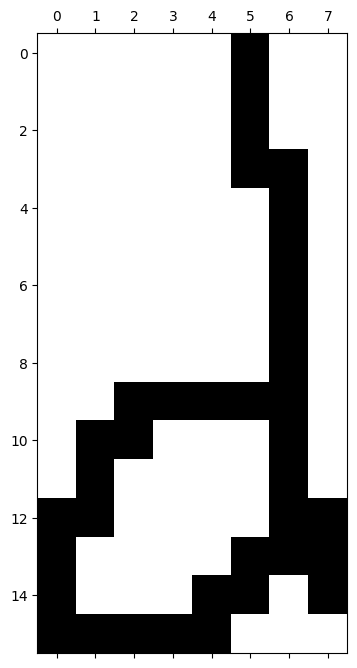

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.gray()
plt.matshow(255 - train_x[0]) # 255 - x simply inverts the fading direction of the image
plt.show()
#train_data[0]

In [24]:
train_class = pd.read_csv(data_path.joinpath("train-target.csv").as_posix(), header=None)
alfa=list(train_class[0].value_counts().index)
alfa.sort()
alfa_dict_num_to_char={i:char for i,char in enumerate(alfa)}
alfa_dict_char_to_num={char:i for i,char in enumerate(alfa)}

train_class_conv=np.zeros((train_class.shape[0],26),dtype=int)
#test_class_conv=np.zeros((test_y.shape[0],26),dtype=int)

for i,char in enumerate(train_class[0]):
    train_class_conv[i][alfa_dict_char_to_num[char]]=1

#for i,char in enumerate(test_class[0]):
#    test_class_conv[i][alfa_dict_char_to_num[char]]=1

#train_y=tf.convert_to_tensor(train_class_conv)
#test_y=tf.convert_to_tensor(test_class_conv)

In [16]:
ms_train_x,ms_val_x=tf.split(train_x,[int(len(train_x)*0.7),len(train_x)-int(len(train_x)*0.7)])
ms_train_y,ms_val_y=tf.split(train_y,[int(len(train_y)*0.7),len(train_y)-int(len(train_y)*0.7)])

In [17]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Softmax, ReLU

class HWCharDeepModelKeras(Model):
    def __init__(self, k):
        super().__init__()
        # Input shape: (batch, 16, 8, 1)
        self.conv1 = Conv2D(
            filters=32, kernel_size=k, padding='same',
            activation='relu', kernel_initializer='he_normal'
        )  # output: (16, 8, 32)
        self.pool1 = MaxPooling2D(pool_size=(2, 2))    # output: (8, 4, 32)

        self.conv2 = Conv2D(
            filters=64, kernel_size=k, padding='same',
            activation='relu', kernel_initializer='he_normal'
        )  # output: (8, 4, 64)
        self.pool2 = MaxPooling2D(pool_size=(2, 2))    # output: (4, 2, 64)

        self.conv3 = Conv2D(
            filters=128, kernel_size=k, padding='same',
            activation='relu', kernel_initializer='he_normal'
        )  # output: (4, 2, 128)
        self.pool3 = MaxPooling2D(pool_size=(2, 2))    # output: (2, 1, 128)

        self.flatten = Flatten()                        # output: (2*1*128 = 256)
        self.fc1 = Dense(512, activation='relu', kernel_initializer='he_normal')
        self.dropout = Dropout(0.5)
        self.fc2 = Dense(26, kernel_initializer='he_normal')
        self.softmax = Softmax()

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=training)
        x = self.fc2(x)
        return self.softmax(x)



In [18]:
def model_sel(epochs,
              max_node_number,
              batch_size_max,
              lrs,
              ms_train_x, ms_train_y,
              ms_val_x, ms_val_y,
              select_n_node=False,
              select_bs=False):
    """
    Esegue model selection testando diverse combinazioni di nodi, batch size e learning rate.

    epochs: numero di epoche
    max_node_number: massimo numero di filtri nei layer convoluzionali
    batch_size_max: massimo esponente di 2 per il batch size (2,4,8,...)
    lrs: minimo esponente negativo di 10 per il learning rate (10^-2,...)
    """

    max_acc = 0
    min_loss = np.inf
    best_params = None

    # Liste di iperparametri
    node_list = range(5, max_node_number+1, 5) if select_n_node else [max_node_number]
    batch_list = range(6, batch_size_max+1) if select_bs else [batch_size_max]
    lr_list = [10**(-i) for i in range(2, lrs+1)]

    for node_number in node_list:
        print(f"\nNode number = {node_number}")

        for batch_exp in batch_list:
            batch_train = 2**(batch_exp+1)
            batch_val = 2**batch_exp
            print(f"   Batch size → train: {batch_train}, val: {batch_val}")

            # Dataset
            train_ds = tf.data.Dataset.from_tensor_slices((ms_train_x, ms_train_y)) \
                                      .shuffle(buffer_size=len(ms_train_x)) \
                                      .batch(batch_train)
            val_ds = tf.data.Dataset.from_tensor_slices((ms_val_x, ms_val_y)) \
                                    .batch(batch_val)

            for lr in lr_list:
                print(f"      Learning rate = {lr}")

                # Inizializza nuovo modello
                model = HWCharDeepModelKeras(node_number)
                model.compile(
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=["accuracy"]
                )

                # Allenamento
                history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    verbose=0
                )

                val_loss, val_acc = model.evaluate(val_ds, verbose=0)

                # Salva best model
                if val_acc*100 > max_acc and val_loss < min_loss:
                    max_acc = val_acc*100
                    min_loss = val_loss
                    best_params = {
                        "node_number": node_number,
                        "batch_train": batch_train,
                        "batch_val": batch_val,
                        "learning_rate": lr,
                        "epochs": epochs,
                        "val_acc": max_acc,
                        "val_loss": min_loss
                    }

                    print(f"New best → {best_params}")

    return best_params

In [19]:
selected_hyp_params=model_sel(35,  5, 6, 5, ms_train_x, ms_train_y, ms_val_x, ms_val_y)


Node number = 5
   Batch size → train: 128, val: 64
      Learning rate = 0.01
New best → {'node_number': 5, 'batch_train': 128, 'batch_val': 64, 'learning_rate': 0.01, 'epochs': 35, 'val_acc': 9.874570369720459, 'val_loss': 2.995889663696289}
      Learning rate = 0.001
New best → {'node_number': 5, 'batch_train': 128, 'batch_val': 64, 'learning_rate': 0.001, 'epochs': 35, 'val_acc': 91.8910264968872, 'val_loss': 0.25311437249183655}
      Learning rate = 0.0001
      Learning rate = 1e-05


In [25]:

train_sp_x,val_sp_x=tf.split(train_x,[int(len(train_x)*0.7),len(train_x)-int(len(train_x)*0.7)])
train_sp_y,val_sp_y=tf.split(train_y,[int(len(train_y)*0.7),len(train_y)-int(len(train_y)*0.7)])

train_ds = tf.data.Dataset.from_tensor_slices((train_sp_x, train_sp_y)).shuffle(10000).batch(selected_hyp_params['batch_train'])
val_ds = tf.data.Dataset.from_tensor_slices((val_sp_x, val_sp_y)).shuffle(10000).batch(selected_hyp_params['batch_train'])

test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(selected_hyp_params['batch_train']//2)

In [26]:
print(selected_hyp_params)
EPOCHS = selected_hyp_params['epochs']
network = HWCharDeepModelKeras(selected_hyp_params['node_number'])

network.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=selected_hyp_params['learning_rate']),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

history = network.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

test_loss, test_acc = network.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc*100:.2f}%")


{'node_number': 5, 'batch_train': 128, 'batch_val': 64, 'learning_rate': 0.001, 'epochs': 35, 'val_acc': 91.8910264968872, 'val_loss': 0.25311437249183655}
Epoch 1/35
229/229 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.1556 - loss: 2.8779 - val_accuracy: 0.5676 - val_loss: 1.4505
Epoch 2/35
229/229 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - accuracy: 0.5992 - loss: 1.3227 - val_accuracy: 0.7113 - val_loss: 0.9565
Epoch 3/35
229/229 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.6965 - loss: 0.9952 - val_accuracy: 0.7664 - val_loss: 0.7743
Epoch 4/35
229/229 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - accuracy: 0.7494 - loss: 0.8226 - val_accuracy: 0.7946 - val_loss: 0.6555
Epoch 5/35
229/229 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - accuracy: 0.7877 - loss: 0.7044 - val_accuracy: 0.8309 - val_loss: 0.5565
Epoch 6/35
229/229 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.8192 - loss: 0.5977 - val_accuracy: 0.8372 - val_loss: 0.5260
Epoch 7/35
229/229 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - a

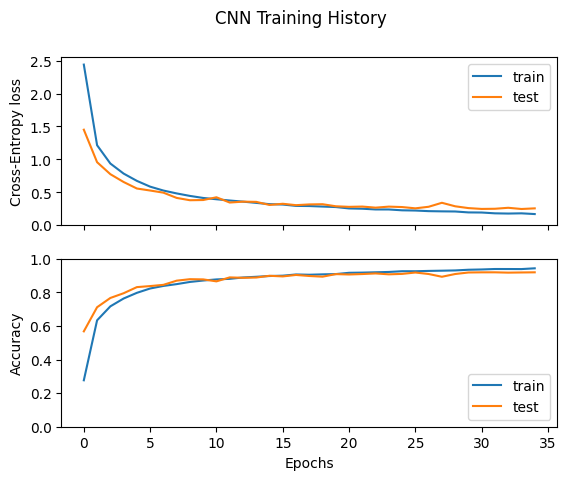

In [27]:
history.history

fig, ax = plt.subplots(nrows=2, sharex=True)

ax[0].plot(history.history["loss"], label="train")
ax[0].plot(history.history["val_loss"], label="test")
ax[0].set_ylabel("Cross-Entropy loss")
ax[0].set_ylim(0)
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="train")
ax[1].plot(history.history["val_accuracy"], label="test")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylim(0, 1)
ax[1].legend()

fig.suptitle("CNN Training History")
fig.savefig("cnn-training.png", dpi=300)


In [28]:
predicted_class=network(test_x,training=False)

list_of_predicted_class=[]
for i in predicted_class:
    ind=int(tf.argmax(i))
    list_of_predicted_class.append(alfa_dict_num_to_char[ind])
# list_of_predicted_class

file = open('predicted_class.txt', 'w')

for char in list_of_predicted_class:
    file.write(char+'\n')

file.close()